In [1]:
!pip install -U datasets

In [2]:
!pip install datasets tensorflow matplotlib scikit-learn

# **1. Load and Explore the Dataset**

In [3]:
from datasets import load_dataset
dataset = load_dataset("AI-Lab-Makerere/beans")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print(dataset)
print(dataset["train"].features)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})
{'image_file_path': Value(dtype='string', id=None), 'image': Image(mode=None, decode=True, id=None), 'labels': ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)}
{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7EE41656E590>, 'labels': 0}


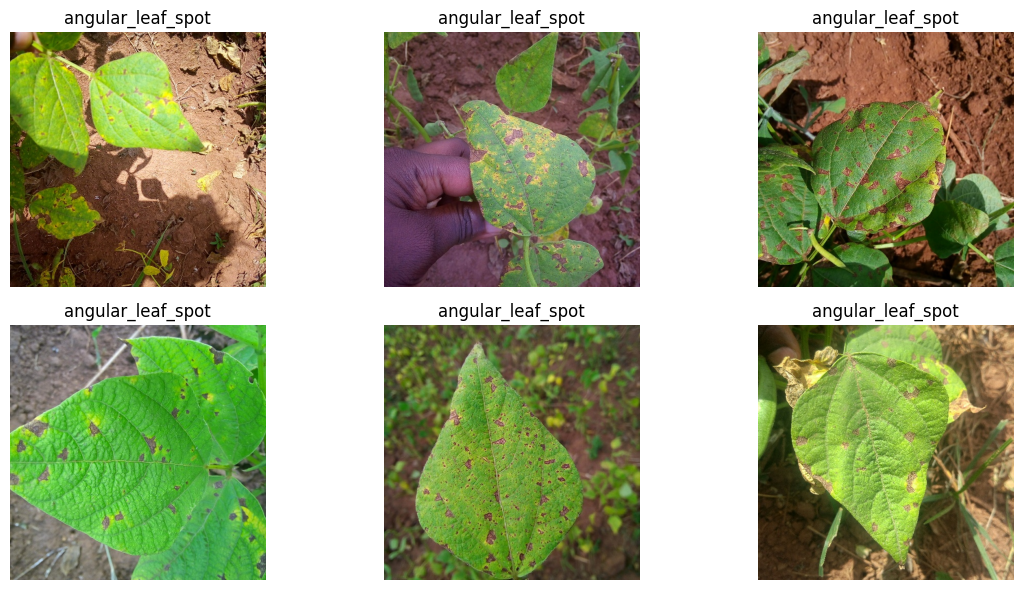

In [5]:
import matplotlib.pyplot as plt

labels = dataset["train"].features["labels"].names

def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        sample = dataset[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(sample["image"])
        plt.title(labels[sample["labels"]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(dataset["train"])

In [6]:
print("Train:", len(dataset["train"]))
print("Validation:", len(dataset["validation"]))
print("Test:", len(dataset["test"]))

Train: 1034
Validation: 133
Test: 128


In [7]:
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [8]:
# Image size and classes
IMG_SIZE = (128, 128)
NUM_CLASSES = 3

# Preprocess images
def preprocess_split(split, max_samples=None):
    from PIL import Image
    images, labels = [], []
    data = split[:max_samples] if max_samples else split
    for example in data:
        img = example["image"].resize(IMG_SIZE).convert("RGB")
        img = np.array(img) / 255.0
        images.append(img)
        labels.append(example["labels"])
    return np.array(images), to_categorical(np.array(labels), NUM_CLASSES)

x_train, y_train = preprocess_split(dataset["train"])
x_val, y_val = preprocess_split(dataset["validation"])
x_test, y_test = preprocess_split(dataset["test"])

# **2. Build a Baseline CNN**

In [9]:
from tensorflow.keras import layers, models

def make_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
# create model
model = make_model()

from tensorflow.keras import callbacks

# early stop to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model.fit(x_train, y_train,
                          validation_data=(x_val, y_val),
                          epochs=15,
                          batch_size=32,
                          callbacks=[early_stop])

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.3519 - loss: 2.2952 - val_accuracy: 0.5113 - val_loss: 1.0653
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4562 - loss: 1.0447 - val_accuracy: 0.6992 - val_loss: 0.8097
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6366 - loss: 0.7999 - val_accuracy: 0.7444 - val_loss: 0.6766
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7347 - loss: 0.6363 - val_accuracy: 0.7820 - val_loss: 0.6229
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7733 - loss: 0.6004 - val_accuracy: 0.6692 - val_loss: 0.7288
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7629 - loss: 0.5717 - val_accuracy: 0.6842 - val_loss: 0.6604
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7983 - loss: 0.5233 - val_accuracy: 0.7368 - val_loss: 0.6186
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8260 - loss: 0.4302 - val_accuracy: 0.7669 -

In [11]:
# accuracy
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy (CNN Base): {acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8042 - loss: 0.5261
Test Accuracy (CNN Base): 0.77


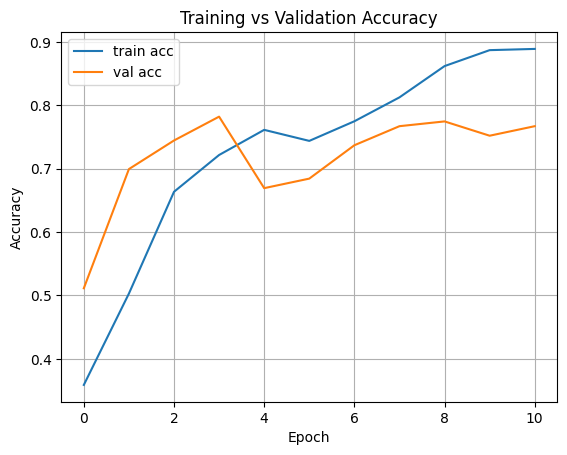

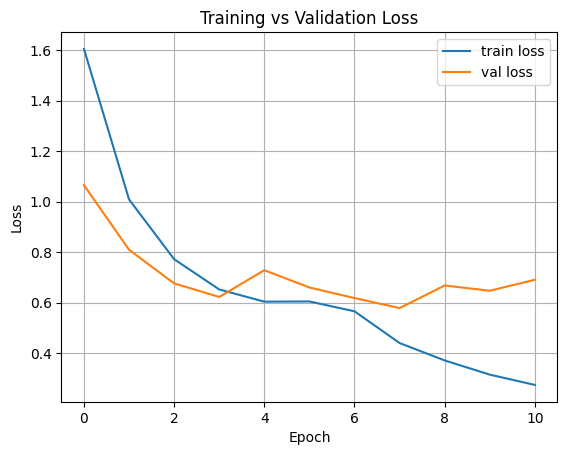

In [12]:
# visualizations
import matplotlib.pyplot as plt

# accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# predictions
y_pred_proba = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [14]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))

                   precision    recall  f1-score   support

angular_leaf_spot       0.76      0.88      0.82        43
        bean_rust       0.73      0.63      0.68        43
          healthy       0.80      0.79      0.80        42

         accuracy                           0.77       128
        macro avg       0.76      0.77      0.76       128
     weighted avg       0.76      0.77      0.76       128



# **3. Apply Transfer Learning**

**MobileNetV2**

In [15]:
# libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np

In [16]:
# preprocessing
def preprocess_for_model(split, preprocess_fn, img_size=(128, 128)):
    from PIL import Image
    images, labels = [], []
    for example in split:
        img = example["image"].resize(img_size).convert("RGB")
        img = preprocess_fn(np.array(img))
        images.append(img)
        labels.append(example["labels"])
    return np.array(images), to_categorical(np.array(labels), 3)
x_train_mob, y_train_mob = preprocess_for_model(dataset["train"], mobilenet_pre)
x_val_mob, y_val_mob = preprocess_for_model(dataset["validation"], mobilenet_pre)
x_test_mob, y_test_mob = preprocess_for_model(dataset["test"], mobilenet_pre)

In [17]:
# model
base_model_mob = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_mob.trainable = False  # congelar capas

inputs = Input(shape=(128, 128, 3))
x = base_model_mob(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax')(x)

model_mob = Model(inputs, outputs)
model_mob.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mob = model_mob.fit(x_train_mob, y_train_mob,
                            validation_data=(x_val_mob, y_val_mob),
                            epochs=15,
                            batch_size=32,
                            callbacks=[early_stop])

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 286ms/step - accuracy: 0.4371 - loss: 1.1583 - val_accuracy: 0.7594 - val_loss: 0.5551
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8167 - loss: 0.4714 - val_accuracy: 0.8346 - val_loss: 0.4089
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8292 - loss: 0.3834 - val_accuracy: 0.8647 - val_loss: 0.3439
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8845 - loss: 0.2984 - val_accuracy: 0.8722 - val_loss: 0.3282
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9204 - loss: 0.2453 - val_accuracy: 0.8722 - val_loss: 0.2811
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9118 - loss: 0.2319 - val_accuracy: 0.8872 - val_loss: 0.2616
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9382 - loss: 0.2019 - val_accuracy: 0.8947 - val_loss: 0.2538
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9453 - loss: 0.1798 - val_accuracy: 0.8872 -

In [19]:
# evaluation
from sklearn.metrics import classification_report

y_pred_mob = np.argmax(model_mob.predict(x_test_mob), axis=1)
y_true_mob = np.argmax(y_test_mob, axis=1)

print("Classification Report - MobileNetV2:")
print(classification_report(y_true_mob, y_pred_mob, target_names=labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Classification Report - MobileNetV2:
                   precision    recall  f1-score   support

angular_leaf_spot       0.80      0.91      0.85        43
        bean_rust       0.87      0.77      0.81        43
          healthy       0.98      0.95      0.96        42

         accuracy                           0.88       128
        macro avg       0.88      0.88      0.88       128
     weighted avg       0.88      0.88      0.87       128



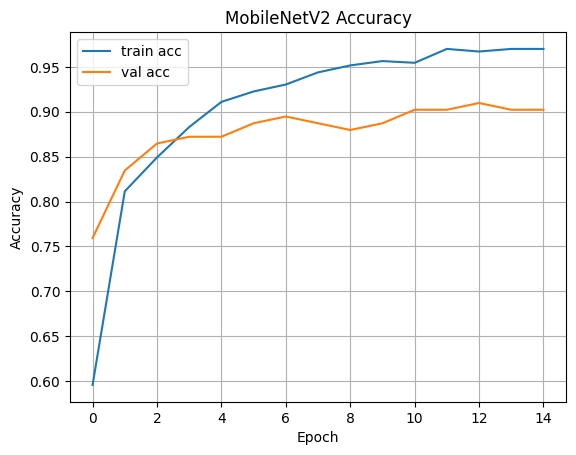

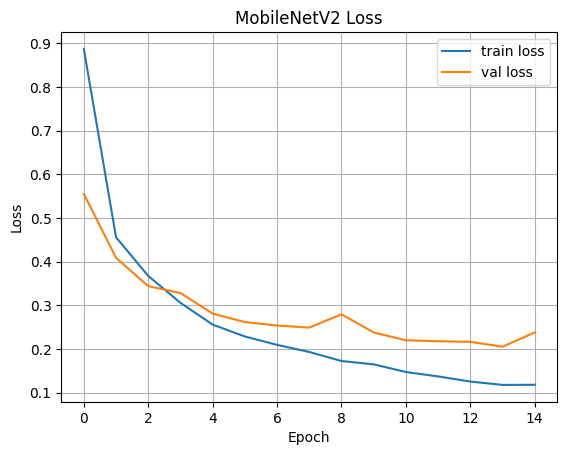

In [20]:
# visualizations
plt.plot(history_mob.history['accuracy'], label='train acc')
plt.plot(history_mob.history['val_accuracy'], label='val acc')
plt.title('MobileNetV2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_mob.history['loss'], label='train loss')
plt.plot(history_mob.history['val_loss'], label='val loss')
plt.title('MobileNetV2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**ResNet 50**

In [21]:
# preprocessing
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre

x_train_res, y_train_res = preprocess_for_model(dataset["train"], resnet_pre)
x_val_res, y_val_res = preprocess_for_model(dataset["validation"], resnet_pre)
x_test_res, y_test_res = preprocess_for_model(dataset["test"], resnet_pre)

In [22]:
# model
base_model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_res.trainable = False

inputs = Input(shape=(128, 128, 3))
x = base_model_res(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(3, activation='softmax')(x)

model_res = Model(inputs, outputs)
model_res.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# training
history_res = model_res.fit(x_train_res, y_train_res,
                            validation_data=(x_val_res, y_val_res),
                            epochs=15,
                            batch_size=32,
                            callbacks=[early_stop])

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 359ms/step - accuracy: 0.5595 - loss: 0.9660 - val_accuracy: 0.8421 - val_loss: 0.4702
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8448 - loss: 0.4176 - val_accuracy: 0.8571 - val_loss: 0.3697
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8920 - loss: 0.3128 - val_accuracy: 0.8797 - val_loss: 0.2939
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9181 - loss: 0.2384 - val_accuracy: 0.8647 - val_loss: 0.3007
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9328 - loss: 0.2094 - val_accuracy: 0.8947 - val_loss: 0.2480
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9631 - loss: 0.1728 - val_accuracy: 0.8647 - val_loss: 0.2314
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9470 - loss: 0.1763 - val_accuracy: 0.8797 - val_loss: 0.2383
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9642 - loss: 0.1450 - val_accuracy: 0.8797 -

In [24]:
# evaluation
y_pred_res = np.argmax(model_res.predict(x_test_res), axis=1)
y_true_res = np.argmax(y_test_res, axis=1)

print("Classification Report - ResNet50:")
print(classification_report(y_true_res, y_pred_res, target_names=labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
Classification Report - ResNet50:
                   precision    recall  f1-score   support

angular_leaf_spot       0.79      0.86      0.82        43
        bean_rust       0.83      0.79      0.81        43
          healthy       1.00      0.95      0.98        42

         accuracy                           0.87       128
        macro avg       0.87      0.87      0.87       128
     weighted avg       0.87      0.87      0.87       128



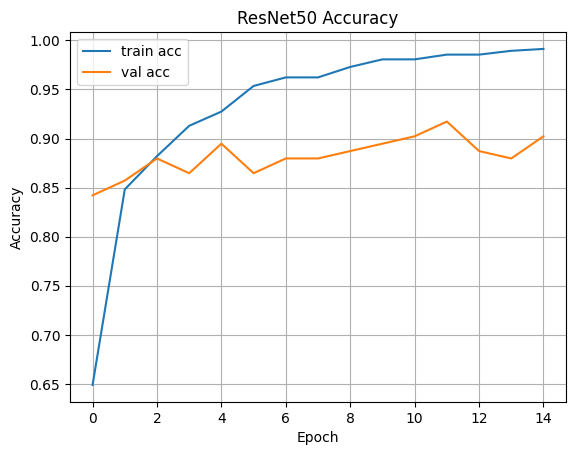

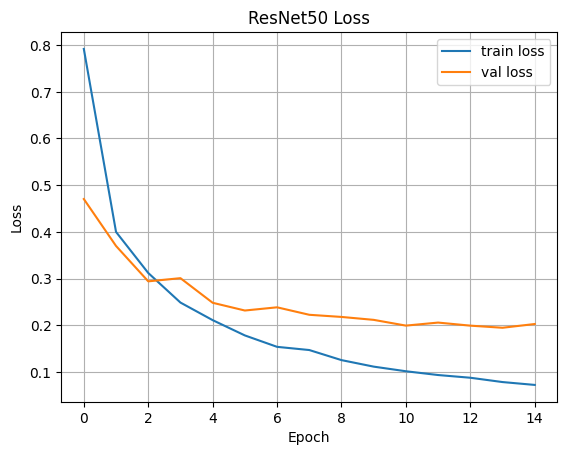

In [25]:
# visualizations
plt.plot(history_res.history['accuracy'], label='train acc')
plt.plot(history_res.history['val_accuracy'], label='val acc')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_res.history['loss'], label='train loss')
plt.plot(history_res.history['val_loss'], label='val loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **4. Evaluation and Reporting**

In [26]:
# libraries
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# retrieves the names of classes from the dataset
labels = dataset["train"].features["labels"].names

In [28]:
# function for making predictions
def evaluate_model(model, x_test, y_test, model_name="Modelo"):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # classification report
    print(f"\n Classification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=labels))

    # confussion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 Classification Report - Baseline CNN
                   precision    recall  f1-score   support

angular_leaf_spot       0.76      0.88      0.82        43
        bean_rust       0.73      0.63      0.68        43
          healthy       0.80      0.79      0.80        42

         accuracy                           0.77       128
        macro avg       0.76      0.77      0.76       128
     weighted avg       0.76      0.77      0.76       128



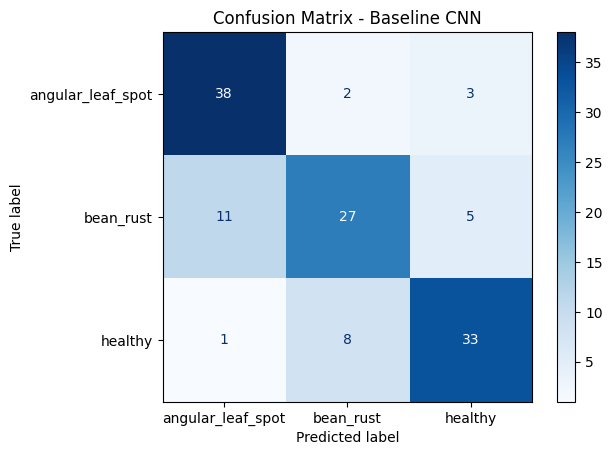

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 Classification Report - MobileNetV2
                   precision    recall  f1-score   support

angular_leaf_spot       0.80      0.91      0.85        43
        bean_rust       0.87      0.77      0.81        43
          healthy       0.98      0.95      0.96        42

         accuracy                           0.88       128
        macro avg       0.88      0.88      0.88       128
     weighted avg       0.88      0.88      0.87       128



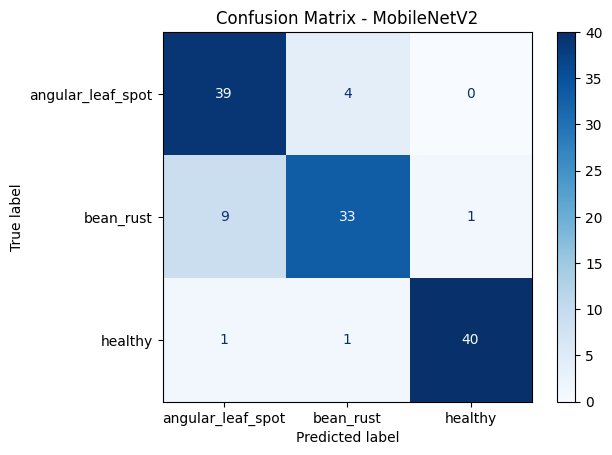

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

 Classification Report - ResNet50
                   precision    recall  f1-score   support

angular_leaf_spot       0.79      0.86      0.82        43
        bean_rust       0.83      0.79      0.81        43
          healthy       1.00      0.95      0.98        42

         accuracy                           0.87       128
        macro avg       0.87      0.87      0.87       128
     weighted avg       0.87      0.87      0.87       128



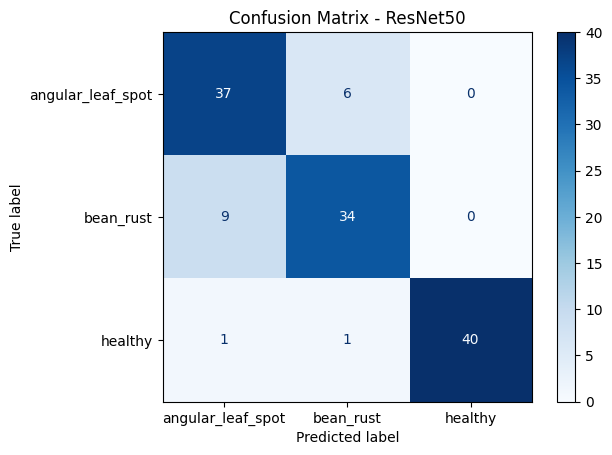

In [29]:
# evaluate models
evaluate_model(model, x_test, y_test, model_name="Baseline CNN")
evaluate_model(model_mob, x_test_mob, y_test_mob, model_name="MobileNetV2")
evaluate_model(model_res, x_test_res, y_test_res, model_name="ResNet50")

**Conclusion**

After comparing the three models, we observe that the pre-trained models (MobileNetV2 and ResNet50) consistently outperform the base CNN model in metrics such as F1-score and overall accuracy, especially in the most difficult to distinguish classes.

The confusion matrix reveals that MobileNetV2 makes fewer cross-classification errors between bean_rust and angular_leaf_spot, while ResNet50 shows a slight improvement in the healthy class.

MobileNetV2 achieves a better balance between accuracy and computational efficiency, making it an ideal choice for production deployments. In contrast, ResNet50 offers the highest accuracy, but at the cost of greater complexity and training time.

In [30]:
model.save("model.keras")
model_mob.save("mobilenet_model.keras")
model_res.save("resnet_model.keras")

Streamlit App: https://huggingface.co/spaces/Ana238/Activity-03